In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

import random

Using TensorFlow backend.


In [2]:
#reading the dataset
#I've split the dataset to hold data for only one person and store it in a separate text file 
#to ensure consistency with respect to time

def readData():
    """
    Reading Data 
    input:
        none
    output:
        data: dataframe with index => DisplayTime value => GlucoseValues
    """
    
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/onePersonData.txt", sep="\t")
    #data.head()
    
    #run only once
    #dropping columns we don't need
    data.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    #df = data['GlucoseValue']
    #df.index = data['Display Time']
    
    #Converting the Display Time to 'datetime' so that it can be used as an index
    data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data = data.set_index(['Display Time'], drop=True)
    #data.head()
    
    return data
    
    
def createGap(data):
    """
    Creating Gap indexes
    input:
        data: dataframe with index => DisplayTime value => GlucoseValues
    output:
        start: seed
        end: seed+gap (gap=250)
    """
    
    seed = random.randint(500,len(data)-500)
    
    return seed,seed+250


def faultyData(df,start,end):
    """
    Creating a Gap
    input:
        start: seed
        end: seed+gap (gap=250)
    output:
        df: dataframe with index => DisplayTime value => GlucoseValues and a gap from start to end (inputs)
    """
    
    #df = readData()
    for i in range(start,end):
        df['GlucoseValue'][i]=0
    
    return df


def index_agreement(s,o):
    """
    index of agreement
    input:
        s: prediceted
        o: original
    output:
        ia: index of agreement
    """
    
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    
    return ia

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: prediceted
        o: original
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: prediceted
        o: original
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))


In [3]:
actual_data = readData()

start,end = createGap(readData())
start2,end2 = createGap(readData())
print(start,end)
print(start2,end2)

gapped_data = readData()
gapped_data = faultyData(gapped_data,start,end-1)
gapped_data = faultyData(gapped_data,start2,end2-1)


553 803
988 1238


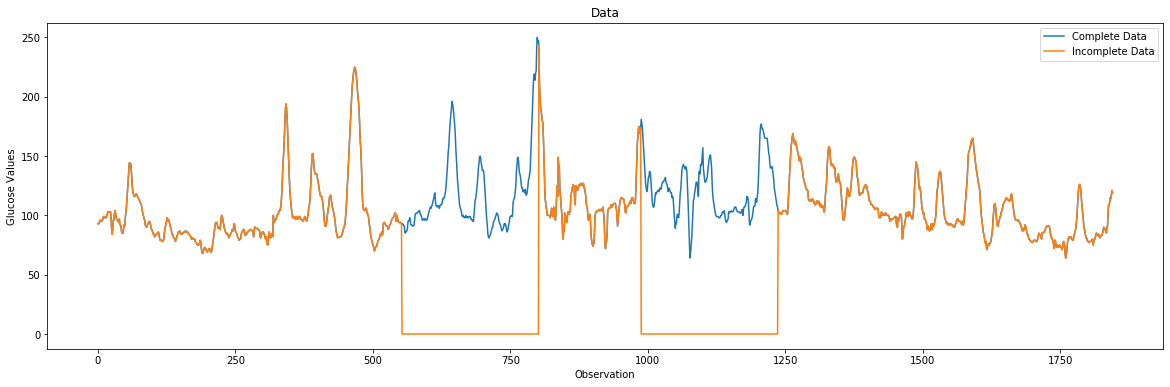

In [4]:
a = actual_data['GlucoseValue'].tolist()
b = gapped_data['GlucoseValue'].tolist()

plt.figure(figsize=(20, 6))
plt.plot(a, label='Complete Data')
plt.plot(b, label='Incomplete Data')
plt.title("Data")
plt.xlabel('Observation')
plt.ylabel('Glucose Values')
plt.legend()
plt.show();

In [5]:


train = actual_data

test1 = actual_data[start:end]
test2 = actual_data[start2:end2]

In [6]:
#print(train)

In [7]:
#print(test)

In [8]:
#scaling => translates each feature individually such that it is in the given range on the training set
#to ensure the unit if our data is not a factor

scaler = MinMaxScaler(feature_range=(0, 1))
train_sc = scaler.fit_transform(train)
#test_sc = scaler.transform(test)

In [9]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

#X_test = test_sc[:-1]
#y_test = test_sc[1:]

In [10]:
#Reshaping the data to work for an LSTM network

train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
#test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    #test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

#X_test = test_sc_df.dropna().drop('Y', axis=1)
#y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

#X_test = X_test.as_matrix()
#y_test = y_test.as_matrix()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
#print('Test shape: ', X_test_lmse.shape)

Train shape:  (1845, 1, 1)


In [12]:
# The LSTM networks creation and model compiling is similar with those of ANN’s.
# The LSTM has a visible layer with 1 input.
# A hidden layer with 7 LSTM neurons.
# An output layer that makes a single value prediction.
# The relu activation function is used for the LSTM neurons.
# The LSTM is trained for 100 epochs and a batch size of 1 is used.

lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=50, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
1845/1845 [==============================] - 5s 3ms/step - loss: 0.0144
Epoch 2/50
1845/1845 [==============================] - 4s 2ms/step - loss: 0.0034
Epoch 3/50
1845/1845 [==============================] - 4s 2ms/step - loss: 9.5360e-04
Epoch 4/50
1845/1845 [==============================] - 4s 2ms/step - loss: 8.5989e-04
Epoch 5/50
1845/1845 [==============================] - 4s 2ms/step - loss: 8.4218e-04
Epoch 6/50
1845/1845 [==============================] - 4s 2ms/step - loss: 8.2241e-04
Epoch 7/50
1845/1845 [==============================] - 4s 2ms/step - loss: 8.0800e-04
Epoch 8/50
1845/1845 [==============================] - 4s 2ms/step - loss: 7.9799e-04
Epoch 9/50
1845/1845 [==============================] - 4s 2ms/step - loss: 7.9703e-04
Epoch 10/50
1845/1845 [==============================] - 4s 2ms/step - loss: 7.9659e-04
Epoch 11/50
1845/1845 [==============================] - 4s 2ms/step - loss: 7.9474e-04
Epoch 12/50
1845/1845 [==========================

In [13]:
#FOR GAP 1
test_sc = scaler.transform(test1)
X_test = test_sc[:-1]
y_test = test_sc[1:]
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test1.index)
for s in range(1,2):
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('LSTM: %f'%lstm_test_mse)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


The R2 score on the Train set is:	0.963
The R2 score on the Test set is:	0.960
249/249 [==============================] - 0s 1ms/step
LSTM: 0.001385


In [14]:
#inversing the scaling
lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
test_val = scaler.inverse_transform(y_test)

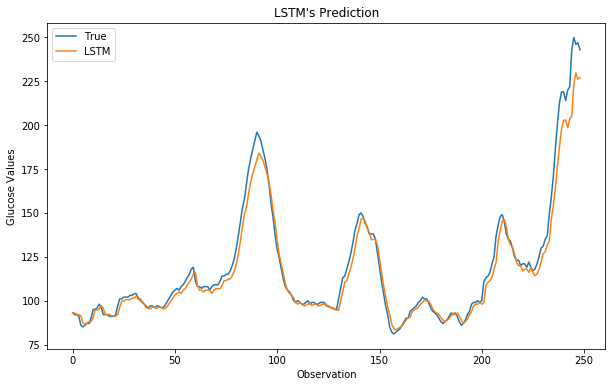

In [15]:
#plotting true values and lstm predicted values
#these are original values

plt.figure(figsize=(10, 6))
plt.plot(test_val, label='True')
plt.plot(lstm_pred, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Glucose Values')
plt.legend()
plt.show();

In [16]:
k=0
for i in range(start,end-1):
    gapped_data['GlucoseValue'][i] = lstm_pred[k]
    k=k+1

In [17]:
#IOA
ioa_val1 = index_agreement(lstm_pred,test_val)
ioa_val1

0.9885989575796825

In [18]:
#MAE
mae_val1 = mae(lstm_pred,test_val)
mae_val1

4.303835734784842

In [19]:
#RMSE
rmse_val1 = rmse(lstm_pred,test_val)
rmse_val1

6.921260034082141

In [20]:
#FOR GAP2
test_sc = scaler.transform(test2)
X_test = test_sc[:-1]
y_test = test_sc[1:]
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test2.index)
for s in range(1,2):
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('LSTM: %f'%lstm_test_mse)

The R2 score on the Train set is:	0.963
The R2 score on the Test set is:	0.941
181/249 [====================>.........] - ETA: 0s

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


249/249 [==============================] - 0s 890us/step
LSTM: 0.000818


In [21]:
#inversing the scaling
lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
test_val = scaler.inverse_transform(y_test)

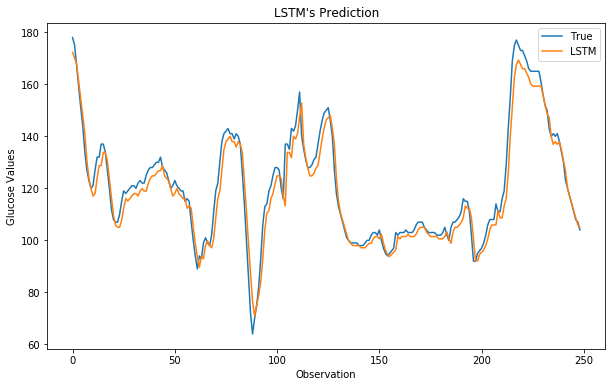

In [22]:
#plotting true values and lstm predicted values
#these are original values

plt.figure(figsize=(10, 6))
plt.plot(test_val, label='True')
plt.plot(lstm_pred, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Glucose Values')
plt.legend()
plt.show();

In [23]:
k=0
for i in range(start2,end2-1):
    gapped_data['GlucoseValue'][i] = lstm_pred[k]
    k=k+1

In [24]:
#IOA
ioa_val2 = index_agreement(lstm_pred,test_val)
ioa_val2

0.9842540431345127

In [25]:
#MAE
mae_val2 = mae(lstm_pred,test_val)
mae_val2

3.9056744556350416

In [26]:
#RMSE
rmse_val2 = rmse(lstm_pred,test_val)
rmse_val2

5.321050776450687

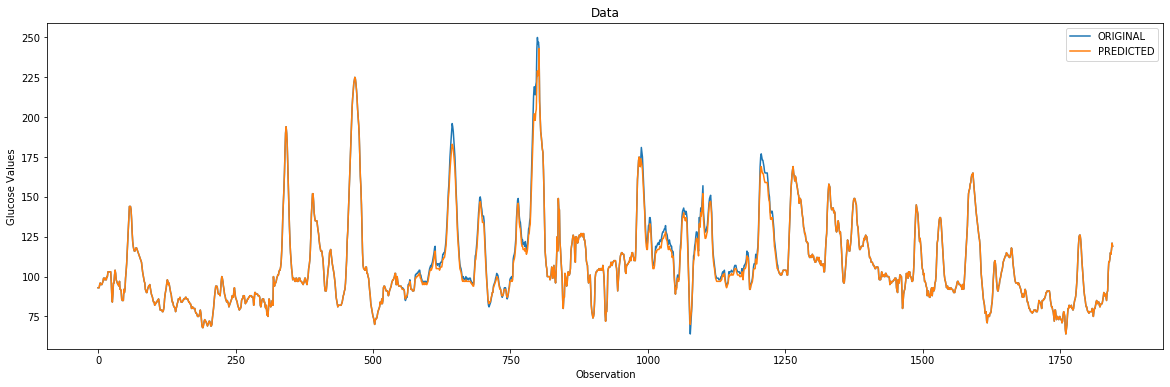

In [27]:
a = actual_data['GlucoseValue'].tolist()
b = gapped_data['GlucoseValue'].tolist()

plt.figure(figsize=(20, 6))
plt.plot(a, label='ORIGINAL')
plt.plot(b, label='PREDICTED')
plt.title("Data")
plt.xlabel('Observation')
plt.ylabel('Glucose Values')
plt.legend()
plt.show();